In [1]:
import csv
import numpy as np
import pandas as pd
import utils 
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

In [2]:
data = np.genfromtxt('repeated_data.csv', delimiter=',', dtype=str)
data = np.delete(data, 0, 0)

In [3]:
data.shape

(28, 17)

In [4]:
new_data = []

# turn each game into entry in this array

def remove_blank(l):
    return list(filter(lambda a: a != '', l))

def replace_letters(l):
   return [[1,0] if x=='c' else [0, 1] for x in l]

for i in range(0, data.shape[0], 2):
    p1 = data[i]
    p2 = data[i+1]

    game = int(p1[0])
    player1 = p1[2]
    player2 = p2[2]
    p1_actions = np.array(replace_letters(remove_blank(p1[3:]))).T
    p2_actions =  np.array(replace_letters(remove_blank(p2[3:]))).T
   
    actions =  [p1_actions, p2_actions]

    new_data.append([game, player1, player2, actions])


In [5]:
df = pd.DataFrame(new_data)
df.columns = ['Game', 'Player_1', 'Player_2', 'Actions']

In [6]:
df.head()

,Game,Player_1,Player_2,Actions
0,0,Faisal,Bharathvaj,"[[[0, 1, 1, 1, 0], [1, 0, 0, 0, 1]], [[1, 0, 1..."
1,1,Yuan,Dagmar,"[[[1, 0, 0], [0, 1, 1]], [[1, 1, 0], [0, 0, 1]]]"
2,2,Ehsan,Mohammend,"[[[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0,..."
3,3,Tao,Rohini,"[[[0, 1, 0, 1, 1], [1, 0, 1, 0, 0]], [[1, 0, 0..."
4,4,Anita,Greg,"[[[1, 1, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 1]..."


In [7]:


for i, row in df.iterrows():
    actions = row.Actions
    plays = np.zeros((2,2))
    for round in range( actions[0].shape[1]): # iterate over length of each game 
        s1 = actions[0][:, round]
        s2 = actions[1][:, round]
        p_outcomes = utils.p_outcomes([s1, s2])
        plays += p_outcomes
      
    # frequency of each
    print(plays/np.sum(plays))
    

[[0.2 0.4]
 [0.2 0.2]]
[[0.33333333 0.        ]
 [0.33333333 0.33333333]]
[[0.5        0.16666667]
 [0.33333333 0.        ]]
[[0.4 0.2]
 [0.2 0.2]]
[[0.57142857 0.14285714]
 [0.28571429 0.        ]]
[[0.5 0.5]
 [0.  0. ]]
[[0.07142857 0.14285714]
 [0.21428571 0.57142857]]
[[0.5 0. ]
 [0.5 0. ]]
[[0.2 0.4]
 [0.4 0. ]]
[[0. 0.]
 [0. 1.]]
[[0.  0. ]
 [0.5 0.5]]
[[0.5 0. ]
 [0.5 0. ]]
[[0.55555556 0.22222222]
 [0.11111111 0.11111111]]
[[0.09090909 0.18181818]
 [0.36363636 0.36363636]]


<AxesSubplot:>

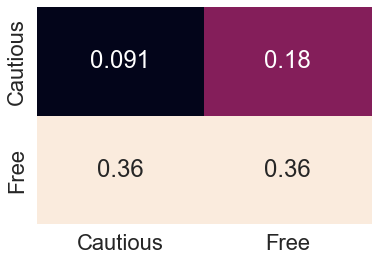

In [8]:
x_axis_labels = ['Cautious', 'Free']
y_axis_labels = ['Cautious', 'Free']
sns.set(font_scale=2) 
sns.heatmap(plays/np.sum(plays), annot=True, cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)


In [9]:
def p_traj(a, s):
    '''
    Returns the probability of a sequence of actions
    a being sampled from strategy s.

    Paramters:
        a : (np.Array) 2 x n array of actions chosen
        s : (np.Array) 2 x n array of strategies 
    '''

    assert a.shape == s.shape
    L = a.shape[1]
    prod = 1
    for l in range(L):
        idx = np.where(a[:, l])
        prod *= s[:, l][idx][0]

    return prod

In [10]:
data = list(df.Actions)
traj = data[0][0][:, 0:3]
s = np.array([[0.9, 0.1], [0.6, 0.4], [.3, .7] ]).T
assert p_traj(traj, s) == 0.018

In [11]:
def p_outcomes(s):
    '''
    returns a probability distribution over outcomes
    '''
    p = s[0]
    for s_i in s[1:]:
        p =  np.multiply.outer(p, s_i)
    return p

def expected_utility(s, payoffs):
    '''
    Gets the expected utilitiy for a player under strategy profile s
    
    Parameters
        s : (list) list where S[i] gives the probability of player i playing each action
        payoffs: (np.array) payoffs for i
    Returns
        eu : (float) expected utility for i
    '''
    p = p_outcomes(s)
    return np.sum(np.multiply(p, payoffs))


In [44]:
payoffs = np.zeros([2, 2, 2])
payoffs[0, :, :] = np.array([[0, -1],
                            [1, -2]])

payoffs[1, :, :] = np.array([[0, 1],
                            [-1, -2]])


a1 = np.array([0.6, 0.4]) 
a2 = np.array([.1, 0.9]) 
assert expected_utility([a1, a2], payoffs=payoffs[0]) == expected_utility([a2, a1], payoffs=payoffs[1])

In [12]:
np.ones(3)[0:-1]

array([1., 1.])

In [13]:
np.ones((2, 8)) / (np.ones(8)*2)


array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [14]:
def ll_uniform( dataset):
    ll = 0
    for play in dataset: 
        for player in range(2):
            traj = play[player]
            s = np.ones_like(traj) / np.ones(traj.shape[1])*2
            ll += np.log(p_traj(traj, s))
    return -ll

ll_uniform(data)

-119.2213150563106

In [68]:
class Level_K_Model:
    def __init__(self, K, h):
        self.K = K
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -1.2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -1.2]])
        self.alphas = None
        self.h = h # the history length


    def log_likelihood_independent(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood. This assumes a players level may change as the game goes on

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        
        alphas = params[0:-2]
        lambda_ = params[-2] 
        kappa  = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                traj = play[player]
                other_traj  = play[1-player] # trajectory of other player
                
                pred_s = self.predict_traj(traj, other_traj, self.K, lambda_, kappa, overall=True, alphas=alphas)  
               
                L = traj.shape[1] #length of trajectory
                for l in range(L):
                    idx = np.where(traj[:, l])
                    ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:-2]
        lambda_ = params[-2] 
        kappa  = params[-1] 
       

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, k in enumerate(range(self.K+1)): # condition on a specific value of k for a player
                    alpha_k = alphas[i]
    
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    pred_s = self.predict_traj(traj, other_traj, k, lambda_, kappa)
                    
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    
                    sum += alpha_k * prob # this could be 0, so small epsilon added

                ll += np.log(sum)
                #print(np.log(sum))

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(self.K+3) # +2 since level 0 and the lambda parameter, kappa parameter
        params[0] = 1 # inital guess is that all players are level 0
        params[-2] = 5 # intial guess for lambda
        params[-1] = 0.5 # intial guess for kappa

        const_arr = np.ones(self.K+3)
        const_arr[-1] = 0
        const_arr[-2] = 0
        #print(const_arr)
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(self.K+1)]
        bnds.append((0, 1000)) 
        bnds.append((0, 1)) 
        #print(bnds)

        result = minimize(
            self.log_likelihood_independent ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
        self.alphas = result.x[0:-1]
        self.lambda_ = result.x[-1]
        ll = result.fun
        return ll


    def predict_traj(self, traj, other_traj, K, lambda_, kappa, overall=False, alphas=None):
        '''
        Returns straetgy predictions against other player
        
        '''
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        L = other_traj.shape[1]
        pred_i = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for other player

        for l in range(L):
            # first determine level 0 strategy 
            start_hist_idx = 0 #max(l-self.h, 0)
            end_hist_idx = l

            if l == 0: # there is no history, so level-0 strategies are uniform
                lvl_0_s_i = np.ones((2)) / 2
                lvl_0_s_other = np.ones((2)) / 2
            else:
                hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions

                w = get_weights(hist_i.shape[1], kappa)
                lvl_0_s_i =  0.99*np.dot(hist_i, w)+ 0.01 * np.ones((2))/2
                lvl_0_s_other=  0.99*np.dot(hist_other, w)+ 0.01 * np.ones((2))/2


            # These become the level 0 strategies
            pred_i[:, 0, l] = lvl_0_s_i
            pred_other[:, 0, l] = lvl_0_s_other

            # Now, for higher levels:
            for k in range(1, K+1):
                pred_i[:, k, l] = 0.999*self.compute_BR(pred_other[:, k-1, l], lambda_) + 0.001 * np.ones((2))/2
                pred_other[:, k, l] =  0.999*self.compute_BR(pred_i[:, k-1, l], lambda_)+ 0.001 * np.ones((2))/2
 

        if overall: # if return the overall prediction
            assert alphas is not None
            pred_i_ = np.zeros((2, L))

            for l in range(L):
                pred_i[:, 0, l] = np.ones((2)) / 2
                pred_i_[:, l] = np.dot(pred_i[:, :, l], alphas)
            pred_i = pred_i_
     
        else:
            pred_i = np.squeeze(pred_i[:, K, :]) # only return the level K predictions


        # if K == 0:
        #     return np.ones((2, L)) / (np.ones(L)*2)
        # else:
        return pred_i   


    def compute_BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])
        #print('EU 0: {}'.format( eu_0))

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        #print('EU 1: {}'.format( eu_1))

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


In [67]:

m = Level_K_Model(2, 3)
ll = m.fit(data)


     fun: 119.05123206137665
     jac: array([-1.71999995e+02, -1.44933311e+02, -1.72000085e+02,  2.95639038e-05,
        1.62124634e-05])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.91015357, 0.        , 0.08984643, 5.42117185, 0.48592246])


In [59]:
t1

array([[0, 1, 1, 1, 0],
       [1, 0, 0, 0, 1]])

In [60]:
t2

array([[1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1]])

In [63]:
t1 = data[0][0]
t2 = data[0][1]
# traj, other_traj, K, lambda_, kappa, overall=False, alphas=None):
m = Level_K_Model(1, 3)
m.predict_traj(t1, t2, 1, 1, 0.5, overall=True, alphas=np.array([0.5, 0.5]))

array([[0.4447357 , 0.38512707, 0.47786173, 0.41353541, 0.4694578 ],
       [0.5552643 , 0.61487293, 0.52213827, 0.58646459, 0.5305422 ]])

In [235]:
class CH_Model(Level_K_Model):
    def log_likelihood_independent(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood. This assumes a players level may change as the game goes on

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        
        alphas = params[0:-2]
        lambda_ = params[-2] 
        kappa  = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                traj = play[player]
                other_traj  = play[1-player] # trajectory of other player
                
                pred_s = self.predict_traj(traj, other_traj, self.K, lambda_, kappa, alphas=alphas)  
               
                L = traj.shape[1] #length of trajectory
                for l in range(L):
                    idx = np.where(traj[:, l])
                    ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood
    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:-1]
        lambda_ = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, k in enumerate(range(self.K+1)): # condition on a specific value of k for a player
                    alpha_k = alphas[i]
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player   
                          
                    pred_s = self.predict_traj(traj, other_traj, k, lambda_, alphas)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * (prob + 0.001) # this could be 0, so small epsilon added

                assert sum != 0
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood

    def fit(self, dataset):


        params = np.zeros(self.K+3) # +2 since level 0 and the lambda parameter
        params[0] = 1 # inital guess is that all players are level 0
        params[-2] = 5 # intial guess for lambda
        params[-1] = 5 # intial guess for kappa

        const_arr = np.ones(self.K+3)
        const_arr[-2] = 0
        const_arr[-1] = 0
        #print(const_arr)
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(self.K+1)]
        bnds.append((0, 1000)) # no bounds for lambda
        bnds.append((0, 1)) # no bounds for kappa
  
        result = minimize(
            self.log_likelihood_independent ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful


    def predict_traj(self, traj, other_traj, K, lambda_, kappa, alphas):
        '''
        Returns straetgy predictions against other player
        
        '''

        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h-1):
                l.append(l[i-1]*kappa)

            l.append(1- np.sum(l))
            #assert np.sum(l) == 1
            l = np.flip(np.array(l))

            return l 


        L = other_traj.shape[1]
        pred_i = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for other player

        for l in range(L):
            # first determine level 0 strategy 
            start_hist_idx = max(l-self.h, 0)
            end_hist_idx = l

            if l == 0: # there is no history, so level-0 strategies are uniform
                lvl_0_s_i = np.ones((2)) / 2
                lvl_0_s_other = np.ones((2)) / 2
            else:
                hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions
                
                w = get_weights(hist_i.shape[1], kappa)
                lvl_0_s_i =  0.99*np.dot(hist_i, w)+ 0.01 * np.ones((2))/2
                lvl_0_s_other=  0.99*np.dot(hist_other, w)+ 0.01 * np.ones((2))/2
            
            # These become the level 0 strategies
            pred_i[:, 0, l] = lvl_0_s_i
            pred_other[:, 0, l] = lvl_0_s_other

            # Now, for higher levels:
            for k in range(1, K+1):
                if np.sum(alphas[0:k]) != 0:
                    s_other = np.matmul(pred_other[:, 0:k, l], alphas[0:k]) / np.sum(alphas[0:k])
                    s_i = np.matmul(pred_i[:, 0:k, l], alphas[0:k]) / np.sum(alphas[0:k])
                else:
                    s_other = np.matmul(pred_other[:, 0:k, l], np.ones(k)/k) 
                    s_i = np.matmul(pred_i[:, 0:k, l], np.ones(k)/k) 
                    
                pred_i[:, k, l] = self.compute_BR(s_other, lambda_)  
                pred_other[:, k, l] = self.compute_BR(s_i, lambda_)
 

        pred_i = np.squeeze(pred_i[:, K, :]) # only return the level K predictions
        return pred_i

In [28]:
pi = np.array([[0.3, 0.7], [0.5, 0.5], [0.9, 0.1]]).T
w = [0.2, 0.3, 0.3]
np.matmul(pi, w) / np.sum(w )

array([0.6, 0.4])

In [240]:
m = CH_Model(3, 4)

t1 = data[0][0]
t2 = data[0][1]

r = m.fit(data)

     fun: 119.22131505631083
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.93190602e-08, 4.99999981e-01, 4.99999981e-01, 1.93541515e-08,
       6.59089494e-09, 4.08512051e-08])


In [ ]:
# reason about future rewards

In [29]:
class Temporal_Model:
    def __init__(self, h=1):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -1]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -1]])
        self.alphas = None
        self.h = h # the history length


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different risk types in population
        gammas = params[3:6] # parameter of risk types in population
        lambda_ = params[-1] 
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, alpha_gamma in enumerate(alphas): # condition on a specific type of  player
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    gamma = gammas[i]
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_gamma * (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(7) # +2 since level 0 and the lambda parameter
    
        for i in range(3):
            params[i] = 1/3

        params[3] = 0.5
        params[4] = 1
        params[5] = 2
        params[6] = 1 # intial guess for lambda

        const_arr = np.zeros(7)
        for i in range(3):
            const_arr[i] = 1

       
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(3)]
       
        bnds.append((-1000, 1))
        bnds.append((1, 1))
        bnds.append((1, 1000))
        bnds.append((0, 1000)) # no bounds for lambda
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint,
            method='SLSQP' )
        print(result)

        assert result.status == 0 # make sure the optimization was successful
    
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''
        L = other_traj.shape[1]
        pred_i = np.zeros((2, L)) # level-k prediction for each stage game for i

        for l in range(L):

            # I could extend this to include history
            if l == 0:
                # if action 0
                s_other_next = self.BR(np.array([1,0]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                # if action 1
                s_other_next = self.BR(np.array([0,1]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
           
            else:
                # if action 0
                s_other_curr = self.BR(traj[:, l-1], lambda_)
                s_other_next = self.BR(np.array([1,0]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                # if action 1
                s_other_curr = self.BR(traj[:, l-1], lambda_)
                s_other_next = self.BR(np.array([0,1]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

            pred_i[:, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

        return pred_i   


    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])


        # if eu_0 >= eu_1:
        #     return np.array([1,0])
        # else:
        #     return np.array([0,1])

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


In [30]:
m = Temporal_Model()

t1 = data[0][0]
t2 = data[0][1]


# alphas = params[0:3] # frequency of different risk types in population
# gammas = params[3:6] # parameter of risk types in population
# lambda_ = params[-1] 
r = m.fit(data)

     fun: 119.22131505631016
     jac: array([-28.        , -28.        , -28.        ,   0.        ,
                nan,   0.        ,   2.49999905])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 1.00000000e+00,  0.00000000e+00,  7.46069873e-13, -6.90858269e+00,
        1.00000000e+00,  1.00000000e+00,  2.54374299e-12])


In [255]:
class Temporal_History_Model:
    def __init__(self, h=1):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None
        self.h = h # the history length



    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different risk types in population
        gammas = params[3:6] # parameter of risk types in population
        lambda_ = params[-2] 
        kappa = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, alpha_gamma in enumerate(alphas): # condition on a specific type of  player
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    gamma = gammas[i]
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, kappa)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_gamma * (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(8)
    
        for i in range(3):
            params[i] = 1/3

        params[3] = 0.5
        params[4] = 1
        params[5] = 2
        params[6] = 1 # intial guess for lambda
        params[7] = 0.8 # intial guess for kappa

        const_arr = np.zeros(8)
        for i in range(3):
            const_arr[i] = 1

       
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(3)]
       
        bnds.append((-1000, 1))
        bnds.append((1, 1))
        bnds.append((1, 1000))
        bnds.append((0, 1000)) # bounds for lambda
        bnds.append((0, 1)) # bounds for kappa
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
    
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma, kappa): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''

        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h-1):
                l.append(l[i-1]*kappa)

            l.append(1- np.sum(l))
            #assert np.sum(l) == 1
            l = np.flip(np.array(l))

            return l 

        L = other_traj.shape[1]
        pred_i = np.zeros((2, L)) # level-k prediction for each stage game for i


        for l in range(L):

            # I could extend this to include history
            if l == 0:
                # if action 0
                s_other_next = self.BR(np.array([1,0]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                # if action 1
                s_other_next = self.BR(np.array([0,1]), lambda_)
                s_i_next = self.BR(s_other_next, lambda_)
                eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
           
            else:
               
                def predicted_eu(action, hist_i):
                    nonlocal lambda_
                    nonlocal kappa
                    w = get_weights(hist_i.shape[1], kappa)
                    s_other_curr = self.BR(np.dot(hist_i, w), lambda_)

                    hist_i_next = np.c_[hist_i, action]
                    w = get_weights(hist_i_next.shape[1], kappa)
                    s_other_next = self.BR(np.dot(hist_i_next, w), lambda_)

                    s_i_next = self.BR(s_other_next, lambda_)
                    eu = expected_utility([action, s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
                    return eu

                #print(eu_0)

                eu_0 = predicted_eu(np.array([1, 0]), traj[:, 0:l])
                eu_1 = predicted_eu(np.array([0, 1]), traj[:, 0:l])
               
              #  print(eu_1)
            pred_i[:, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

        return pred_i   


    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        return softmax(np.array([eu_0, eu_1])*lambda_)


In [256]:
m = Temporal_History_Model()
r = m.fit(data)

     fun: 114.69670137451106
     jac: array([-2.80000658e+01, -2.75068636e+01, -2.79998741e+01, -1.23977661e-05,
                   nan,  7.15255737e-05,  8.31604004e-04,  5.81382751e-01])
 message: 'Optimization terminated successfully'
    nfev: 256
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([ 0.64230928,  0.        ,  0.35769072, -2.08531107,  1.        ,
        2.32722277,  0.57139714,  0.        ])


In [ ]:
# reason about future and I have a level of reasoning

In [33]:

class Temporal_Level_Model:
    def __init__(self):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -1]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -1]])
        self.alphas = None
       

    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different reasoning types in the population
        alpha_gammas = params[3:6]  # parameter for forward looking type
        gammas = params[6:9]
        
        lambda_ = params[-2] 
        kappa = params[-1] 
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for k, alpha_k in enumerate(alphas): # condition on a specific type of  player
                    for i, alpha_gamma in enumerate(alpha_gammas): # condition on a specific type of  player
                        traj = play[player]
                        other_traj  = play[1-player] # trajectory of other player
                        gamma = gammas[i]
                        pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k)
                        prob = p_traj(traj, pred_s) # probability of that trajectory
                        sum += alpha_k * alpha_gamma* (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


        # ll = 0
        # for play in dataset: 
        #     for player in range(2):
        #         traj = play[player]
        #         other_traj  = play[1-player] # trajectory of other player    
        #         pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa)
                   
        #         L = traj.shape[1] #length of trajectory
        #         for l in range(L):
        #             idx = np.where(traj[:, l])
        #             ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def predict(self, params):
        alphas = params[0:3] # frequency of different reasoning types in the population
        alpha_gammas = params[3:6]  # parameter for forward looking type
        gammas = params[6:9]
        
        lambda_ = params[-2] 
        kappa = params[-1] 


        pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k)

    def fit(self, dataset):
        params = np.zeros(11)
    
        for i in range(6):
            params[i] = 1/3

        params[7] = 0 # lambda
        params[8] = 1 # lambda
        params[9] = 10 # lambda
        params[10] = 1 # lambda
    

        const_arr1 = np.zeros(11)
        for i in range(3):
            const_arr1[i] = 1
       
        constraint1 = LinearConstraint(const_arr1, lb=1, ub=1)
       
        const_arr2= np.zeros(11)
        for i in range(3, 6):
            const_arr2[i] = 1
       
        constraint2 = LinearConstraint(const_arr2, lb=1, ub=1)
        
        bnds = [(0, 1) for x in range(6)]
        bnds.append((0, 1)) # gamma 1
        bnds.append((1, 1)) # kgamma 2
        bnds.append((1, 100)) # gamma 2
        bnds.append((0, 1000)) # lambda
        bnds.append((0, 1)) # kappa
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=[constraint1, constraint2]) 
        print(result)

        assert result.status == 0 # make sure the optimization was successful
        return result
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma, alphas, kappa, k): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''


        L = other_traj.shape[1]
        pred_i = np.zeros((2, len(alphas), L)) # level-k prediction for each stage game for 
        
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        for l in range(L):
            for k in range(len(alphas)):
                if k == 0:
                    pred_i[:, k, l] = np.ones(2)/2

                if k == 1:
                    
                    if l == 0:
                        # if action 0                   
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) 
                        # if action 1                 
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0])
                
                    else:
                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
                        s_other_curr = self.BR(np.dot(hist, w), lambda_)
                        # if action 0
                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0])
                        # if action 1
                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) 

                    
                    pred_i[:, k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

                if k == 2:
                    if l == 0:
                        # if action 0
                        s_other_next = self.BR(np.array([1,0]), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1
                        s_other_next = self.BR(np.array([0,1]), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
                
                    else:
                        # if action 0

                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
        
                        s_other_curr = self.BR(np.dot(hist, w), lambda_)

                        hist_new = np.c_[hist, np.array([1,0]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)

                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1

                        hist_new = np.c_[hist, np.array([0,1]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)

                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                    pred_i[:,k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))


        pred_i_ = np.zeros((2, L))

        # for l in range(L):
        #     pred_i_[:, l] = np.dot(pred_i[:, :, l], alphas)
        # pred_i = pred_i_

        pred_i = np.squeeze(pred_i[:, k, :])
        
        return pred_i   


    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        return softmax(np.array([eu_0, eu_1])*lambda_)

In [34]:
m = Temporal_Level_Model()
m.fit(data)
t1 = data[0][0]
t2 = data[0][1]


# print(t1)
#print(m.predict_traj(t1, t2, lambda_=1, gamma=1, k=1))
# print(t2)
# # m.predict_traj(t1, t2, 2, 5, overall=True, alphas=[0, 1, 0])

#m.log_likelihood( [1, 0, 0, 1, 1, 0.25], data)
# print(m.predict_traj(t2, t1, 2, 1000))


     fun: 119.22131506645408
     jac: array([-28. , -28. , -28. , -28. , -28. , -28. ,   0. ,   nan,   0. ,
         2.5,   0. ])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([3.33333333e-01, 3.33333333e-01, 3.33333333e-01, 9.99999983e-01,
       8.54528648e-09, 8.54487797e-09, 1.79405561e-07, 1.00000000e+00,
       1.00000000e+00, 4.05739975e-09, 4.27333134e-07])


In [52]:

class Temporal_Level_Model:
    def __init__(self):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0.5, -1],
                                          [1, 0]])
        self.payoffs[1, :, :] = np.array([[0.5, 1],
                                         [-1, 0]])
        self.alphas = None
       


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different reasoning types in the population
        
        gamma = params[-3]  # parameter for forward looking type
        lambda_ = params[-2] 
        kappa = params[-1] 
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for k, alpha_k in enumerate(alphas): # condition on a specific type of  player
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                  
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


        # ll = 0
        # for play in dataset: 
        #     for player in range(2):
        #         traj = play[player]
        #         other_traj  = play[1-player] # trajectory of other player    
        #         pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa)
                   
        #         L = traj.shape[1] #length of trajectory
        #         for l in range(L):
        #             idx = np.where(traj[:, l])
        #             ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(6) # +2 since level 0 and the lambda parameter
    
        for i in range(3):
            params[i] = 1/3

        params[3] = 0.5 #gamma 
        params[4] = 1 # lambda
        params[5] = 0.5 # kappa

        const_arr = np.zeros(6)
        for i in range(3):
            const_arr[i] = 1
       
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(3)]
       
        bnds.append((0, 1)) 
        bnds.append((0, 1000)) # lambda
        bnds.append((0, 1)) 
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        #print(result)

        assert result.status == 0 # make sure the optimization was successful
        return result
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma, alphas, kappa, k): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''


        L = other_traj.shape[1]
        pred_i = np.zeros((2, len(alphas), L)) # level-k prediction for each stage game for 
        
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        for l in range(L):
            for k in range(len(alphas)):
                if k == 0:
                    pred_i[:, k, l] = np.ones(2)/2

                if k == 1:
                    
                    if l == 0:
                        # if action 0                   
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) 
                        # if action 1                 
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0])
                
                    else:
                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
                        s_other_curr = self.BR(np.dot(hist, w), lambda_)
                        # if action 0
                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0])
                        # if action 1
                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) 

                    
                    pred_i[:, k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

                if k == 2:
                    if l == 0:
                        # if action 0
                        s_other_next = self.BR(np.array([1,0]), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1
                        s_other_next = self.BR(np.array([0,1]), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
                
                    else:
                        # if action 0

                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
        
                        s_other_curr = self.BR(np.dot(hist, w), lambda_)

                        hist_new = np.c_[hist, np.array([1,0]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)

                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1

                        hist_new = np.c_[hist, np.array([0,1]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)

                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                    pred_i[:,k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))


        pred_i_ = np.zeros((2, L))

        # for l in range(L):
        #     pred_i_[:, l] = np.dot(pred_i[:, :, l], alphas)
        # pred_i = pred_i_

        pred_i = np.squeeze(pred_i[:, k, :])
        
        return pred_i   


    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        return softmax(np.array([eu_0, eu_1])*lambda_)


In [53]:
m = Temporal_Level_Model()
print(m.fit(data))
t1 = data[0][0]
t2 = data[0][1]

     fun: 119.22131505632876
     jac: array([-28.  , -28.  , -28.  ,  -0.  ,   3.75,   0.  ])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([3.33333333e-01, 3.33333333e-01, 3.33333333e-01, 1.00000000e+00,
       4.83524332e-12, 6.65023592e-14])
